# Anomaly Detection Challenge
The goal of this notebook is to build a model to classify the sample of the anomaly detection challenge. Since the problem regards exactly *anomaly detection*, the focus of the modelization part is on interpretability.
The notebook is divided in the following parts:
- **[0. Environment Setup](#0.-Environment-Setup)**
- **[1 . Data Exploration](#1.-Data-Exploration)**
    - **[1.1 Target null values count plot](#1.1-Target-null-values-count-plot)**
    - **[1.2 Distribution Analysis](#1.2-Distribution-Analysis)**
- **[2 . Data Preprocessing](#2.-Data-Preprocessing)**
- **[3 . Model Selection](#3.-Model-Selection)**
    - **[3.1 Decision Tree Classifier](#3.1-Decision-Tree-Classifier)**
    - **[3.2 Random Forest Classifier](#3.2-Random-Forest-Classifier)**
    - **[3.3 Other models](#3.3-Other-models)**
    - **[3.4 Suggested Models](#3.4-Suggested-Models)**
- **[4 . Parameters Optimization](#4.-Parameters-Optimization)**
    - **[4.1 Decision Tree Parameters Optimization](#4.1-Decision-Tree-Parameters-Optimization)**
    - **[4.2 Random Forest Parameters Optimization](#4.2-Random-Forest-Parameters-Optimization)**
- **[5. Interpret the models](#5.-Interpret-the-models)**
- **[6. Conclusion and final score](#6.-Conclusion-and-final-scores)**

### 0. Environment Setup

In [131]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import datetime

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils import resample
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.tree.export import export_graphviz

from time import time

from matplotlib import gridspec
from functools import reduce

from ruleset import BayesianRuleSet
import pysbrl

# global variable
check_names = ['Check1', 'Check2', 'Check3', 'Check4', 'Check5', 'Check6', 'Check7', 'Check8']

In [104]:
# Utility function
def fill_na_train(original_df):
    """
    Fill the NaN values of the training dataset with the most appropriate value (e.g. Median or 0).
    Parameters:
    original_df (pandas.DataFrame): training dataframe

    Returns:
    df (pandas.DataFrame): dataframe with filled NaN
    filled_values (dict): dictionary containing values used to fill NaN
    """
    df = original_df.copy()
    # dictionary which contains values used to fill na features (useful for filling the test set)
    filled_values = {}

    filled_values['BlockingPhaseSec'] = 0
    filled_values['DiagnosisFiles'] = 0
    filled_values['DiagnosisFilesSize'] = 0
    filled_values['MergeErrors'] = 0

    filled_values['LogSegmentChange'] = original_df['LogSegmentChange'].mode()[0]

    filled_values['IndexServerAllocationLimit'] = original_df['IndexServerAllocationLimit'].median()
    filled_values['CPU'] = original_df['CPU'].median()
    filled_values['InstanceMEM'] = original_df['InstanceMEM'].median()
    filled_values['PhysMEM'] = original_df['PhysMEM'].median()
    filled_values['LargestTableSize'] = original_df['LargestTableSize'].median()
    filled_values['Disk'] = original_df['Disk'].median()
    filled_values['TablesAllocation'] = original_df['TablesAllocation'].median()
    filled_values['DeltaSize'] = original_df['DeltaSize'].median() # CHECK
    filled_values['LargestPartitionSize'] = original_df['LargestPartitionSize'].median()
    filled_values['CompositeOOMDums'] = original_df['CompositeOOMDums'].median()
    filled_values['Dumps'] = original_df['Dumps'].median()

    for k, v in filled_values.items():
        df[k] = df[k].fillna(v)
    
    return df, filled_values

def fill_na_test(original_df, values):
    """
    Fill the dataframe NaN values using through the dictionary
    
    Parameters:
    original_df (pandas.DataFrame): original dataframe
    values (dict): dictionary used to fill the dataset

    Returns:
    df (pandas.DataFrame): dataframe with filled NaN
    
    """
    df = original_df.copy()
    for k, v in values.items():
        df[k] = df[k].fillna(v)

    return df

def features_drop(original_dataset):
    """
    Drop the features that have been consired not useful for the modelling phase.
    """
    original_dataset = original_dataset.drop(['CleanupOOMDumps','PreprocessorRestarts','DaemonRestarts', 'SessionNumber', 'SystemID', 'Date'], axis=1)
    return original_dataset

def drop_na_rows(original_dataset):
    """
    Drop every row containing at least one missing feature.
    """
    df = original_dataset.copy()
    return df.dropna(how='any')


def downsample_major(dataset, check_no, mul_val=1):
    """
    Downsample minority class
    """
    df_majority = dataset[cleaned_df["Check{}".format(check_no)]==0]
    df_minority = cleaned_df[cleaned_df["Check{}".format(check_no)]==1]

    # Downsample majority class
    df_majority_downsampled = resample(df_majority, 
                                     replace=False,
                                     n_samples=mul_val * len(df_minority))

    df_downsampled = pd.concat([df_majority_downsampled, df_minority])
    return df_downsampled

def oversample_minor(dataset, check_no, div_val=1):
    """
    Oversample minority class
    """
    df_majority = dataset[cleaned_df["Check{}".format(check_no)]==0]
    df_minority = cleaned_df[cleaned_df["Check{}".format(check_no)]==1]

    # Downsample majority class
    df_minority_oversampled = resample(df_minority, replace=True, n_samples=len(df_majority) // div_val)

    df_downsampled = pd.concat([df_majority, df_minority_oversampled])
    return df_downsampled


def train_test_check_x(original_df, checkNo, test_size=0.3):
    """
    Handler function to clean, preprocess and split the dataframe. 

    Parameters:
    original_df (pandas.DataFrame): original dataframe
    checkNo (int): check number
    values (dict): dictionary used to fill the dataset    reg_behaviour: if set to True, label 0 will represent samples which have all checks equal to 0 (no anomalies)
    test_size : see train_test_split
    
    Returns:
    X_train, X_test, y_train, y_test : see train_test_split
    """

    if checkNo < 1 or checkNo > 8:
        raise Exception('Check number must be between 1 and 8')
    check_str = 'Check'+str(checkNo)
    
    # keep the original dataframe and modify a copy of it
    df = original_df.copy()

    # remove rows with checkNo == NaN
    df = df[~df[check_str].isna()]

    targets = df[check_str]
    inputs = df.drop(check_names, axis=1)

    X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=test_size, stratify=targets)

    # fill na values in train and test input set
    X_train, filled_values = fill_na_train(X_train)
    X_test = fill_na_test(X_test, filled_values)

    return X_train, X_test, y_train, y_test

def print_scores(y_pred, y_test):
    """
    Print the scores of the model
    """
    print("Score values of the model:")
    print("\tF1 'macro' score: {0:.2f}%".format(100 * f1_score(y_test, y_pred, average='macro')))
    print("\tF1 Binary score on label 0 : {:.2f}%".format(100 * f1_score(y_test, y_pred, average='binary', pos_label=0)))
    print("\tF1 Binary score on label 1 : : {:.2f}%".format(100 * f1_score(y_test, y_pred, average='binary', pos_label=1)))
    print("\tAccuracy 'macro' score: {:.2f}%".format(100 * f1_score(y_test, y_pred, average='macro')))
    print("\tAccuracy score: {:.2f}%\n".format(100 * accuracy_score(y_test, y_pred)))

In [87]:
# the header is not present in the file, then the names have been written here
header = ['SessionNumber',
 'SystemID',
 'Date',
 'HighPriorityAlerts',
 'Dumps',
 'CleanupOOMDumps',
 'CompositeOOMDums',
 'IndexServerRestarts',
 'NameServerRestarts',
 'XSEngineRestarts',
 'PreprocessorRestarts',
 'DaemonRestarts',
 'StatisticsServerRestarts',
 'CPU',
 'PhysMEM',
 'InstanceMEM',
 'TablesAllocation',
 'IndexServerAllocationLimit',
 'ColumnUnloads',
 'DeltaSize',
 'MergeErrors',
 'BlockingPhaseSec',
 'Disk',
 'LargestTableSize',
 'LargestPartitionSize',
 'DiagnosisFiles',
 'DiagnosisFilesSize',
 'DaysWithSuccessfulDataBackups',
 'DaysWithSuccessfulLogBackups',
 'DaysWithFailedDataBackups',
 'DaysWithFailedfulLogBackups',
 'MinDailyNumberOfSuccessfulDataBackups',
 'MinDailyNumberOfSuccessfulLogBackups',
 'MaxDailyNumberOfFailedDataBackups',
 'MaxDailyNumberOfFailedLogBackups',
 'LogSegmentChange',
 'Check1',
 'Check2',
 'Check3',
 'Check4',
 'Check5',
 'Check6',
 'Check7',
 'Check8']

In [88]:
raw_df = pd.read_csv('/mnt/datasets/anomaly/data.csv', sep=';', header=None, names=header)

In [89]:
print("Dataset lenght: {}".format(len(raw_df)))
raw_df.head()

Dataset lenght: 287031


,SessionNumber,SystemID,Date,HighPriorityAlerts,Dumps,CleanupOOMDumps,CompositeOOMDums,IndexServerRestarts,NameServerRestarts,XSEngineRestarts,...,MaxDailyNumberOfFailedLogBackups,LogSegmentChange,Check1,Check2,Check3,Check4,Check5,Check6,Check7,Check8
0,0,0,16/01/2017 04:04,1,0.0,0.0,0.0,0,0,0,...,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
1,1,1,06/02/2017 04:03,0,0.0,0.0,0.0,0,0,0,...,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
2,2,1,20/02/2017 04:03,0,0.0,0.0,0.0,0,0,0,...,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
3,3,2,13/02/2017 04:44,1,0.0,0.0,0.0,0,0,0,...,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
4,4,3,06/02/2017 04:31,1,0.0,0.0,0.0,0,0,0,...,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0


### 1. Data Exploration
Below are shown the count of NaN values for each feature.

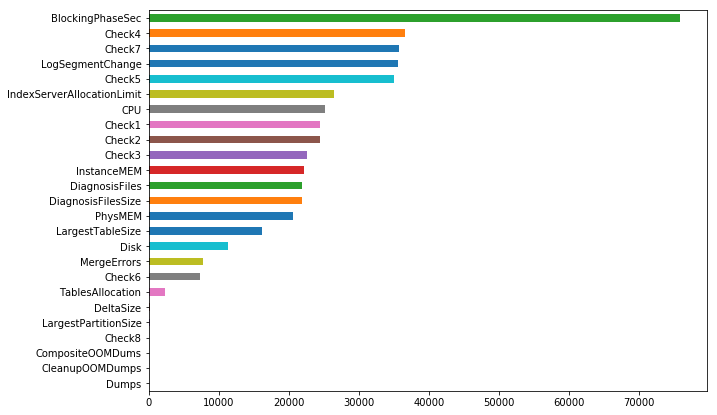

In [90]:
# aggregate all null values 
dataset_na = raw_df.isnull().sum()

# get rid of all the values with 0 missing values and plot 
dataset_na = dataset_na.drop(dataset_na[dataset_na == 0].index).sort_values(ascending=True)
plt.subplots(figsize =(10, 7))
dataset_na.plot(kind='barh');

As shown below some columns have only one value so they are useless for this classification problem

In [91]:
# 'CleanupOOMDumps' 
print(raw_df['CleanupOOMDumps'].unique(), "Number of NaN values: ", len(raw_df[raw_df['CleanupOOMDumps'].isna()]))

# 'PreprocessorRestarts'
print(raw_df['PreprocessorRestarts'].unique())

# 'DaemonRestarts'
print(raw_df['DaemonRestarts'].unique())

[ 0. nan] Number of NaN values:  3
[0]
[0]


In practice the dataframe has only zero on these features.

### 1.1 Target null values count plot
Here are displayed the countplots on the number of null values for each target.

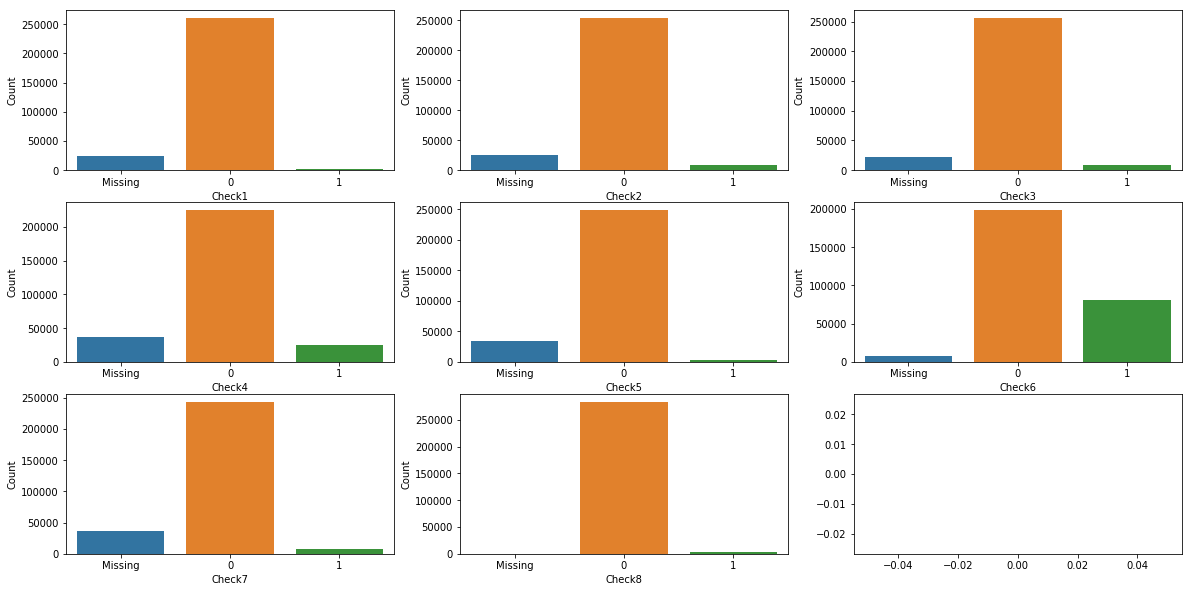

In [92]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))

for i, label in enumerate(check_names):
    check = raw_df[label].fillna('Missing')
    sns.countplot(x=check, ax=ax[i // 3][i % 3], order=['Missing', 0, 1])
    ax[i // 3][i % 3].set_ylabel('Count')
    ax[i // 3][i % 3].set_xlabel(label)
plt.axis('equal')
plt.show()

Since we do not know the meaning of the NaN value in this context, we suppose a NaN value is a "skipped" check. Therefore, we do not consider those samples when we train a model on that specific check.

### 1.2 Distribution Analysis
**Regular Behaviour**: all the samples with *all* the check to 0 are considered to be following a regular behaviour, meaning that they refer to operations which do not present *any* anomaly.
The function above allow to display the distribution for each feature of the "Regular Behaviour" samples compared to the ones with selected check to 1.

In [93]:
def display_distribution_per_feature(feat, dataset_regular_behaviour, dataset, n_graph_per_column=4, n_graph_total=8):
    """
    Display the distribution of a selected feature comparing the regular behaviour samples and the samples on with check-i=1 

    Example usage:
        display_distribution_per_feature('IndexServerAllocationLimit', dataset_regular_behaviour, dataset)
    """
    fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(15, 15))
    x_val, y_val = n_graph_per_column, n_graph_total // n_graph_per_column

    gs = gridspec.GridSpec(x_val, y_val, figure=fig)
    print("Analysis of the distribution of the feature: {}".format(feat))
    for check_num in range(1, 9):
            ax = plt.subplot(gs[(check_num - 1) % n_graph_per_column, (check_num - 1) // n_graph_per_column])
            sns.distplot(dataset_regular_behaviour[feat][~dataset_regular_behaviour[feat].isna()], color='blue')#,rug=False, kde=False)
            sns.distplot(dataset[feat][dataset['Check' + str(check_num)]==1][~dataset[feat].isna()], color='red')#,rug=False,kde=False)
            ax.set(yscale="log")
            ax.legend(['regular Behaviour', 'Check' + str(check_num)], loc='best')
            ax.set_xlabel('value')
            ax.set_title('Distribution of feature: ' + feat)

    plt.subplots_adjust(bottom=0.05, top=1.2)
    plt.show()

The function above has been initially called for each feature. The goal was to spot different distributions regarding regular behaviour and anomalous samples. What we found is that for some features the distributions have a different shape, mean and variance.

We do not report every plot since it would be too verbose. An iconic example is displayed below regarding the features *CPU*. It is possible to notice that both for *Check1* and *Check6* the distributions are extremely different, and over a certain threshold of CPU there are no regular Behaviour samples.

In [94]:
dataset_regular_behaviour = pd.DataFrame(features_drop(raw_df))
for i in range(8):
    label = 'Check' + str( i + 1)
    dataset_regular_behaviour = dataset_regular_behaviour[dataset_regular_behaviour[label] == 0]

Analysis of the distribution of the feature: CPU


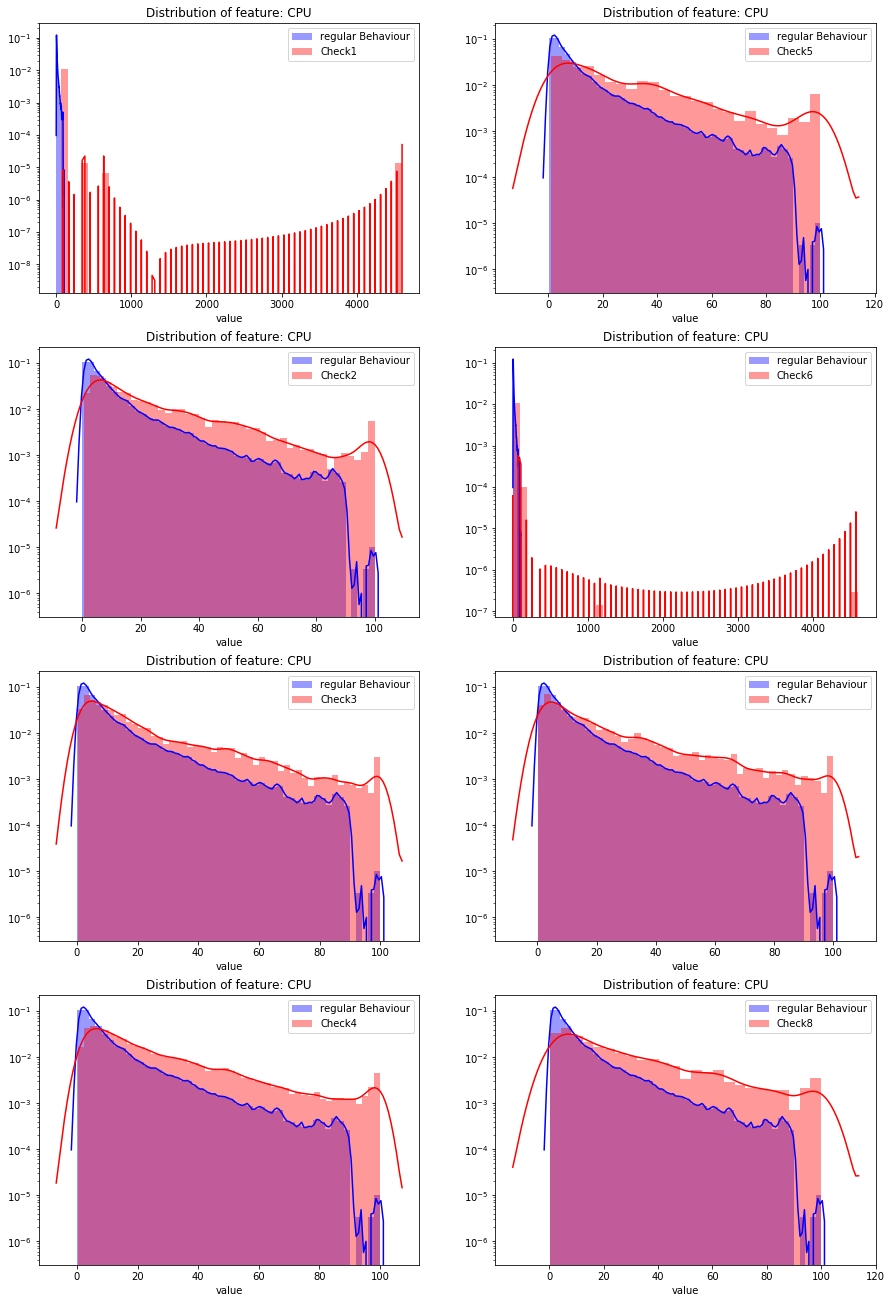

In [41]:
### Show usage of the function.
display_distribution_per_feature('CPU', dataset_regular_behaviour, raw_df)
# display_distribution_per_feature('TablesAllocation', dataset_regular_behaviour, dataset)
# display_distribution_per_feature('IN', dataset_regular_behaviour, dataset)

Through the visualization of the distribution of the features of *regular behaviour* samples and the samples with correspective CheckX to 1, it is possible to visualize the difference in terms of mean and variance. For all the checks except 7 we noticed really different distributions respect to at least one feature.

## 2. Data Preprocessing
Regarding the time, our hypotesis is that it is not relevant in this analysis, since the samples of log of a DB system *should* not be stateful. Nevertheless, we do not exclude that there could be a correlation between time and the checks of the sample. Here it is done the mapping into seconds in case we decide to exploit this feature for *stateful* model (which probably will show less/no interpretability).

In [155]:
# No reason to run for debugging
epoch = datetime.datetime.utcfromtimestamp(0)

def unix_time_millis(dt):
    return (dt - epoch).total_seconds() * 1000.0
raw_df['Date'] = pd.to_datetime(raw_df['Date'], errors='coerce')
raw_df['Date'] = raw_df['Date'].map(unix_time_millis)

Drop of unlabeled samples. (all checks to NaN)

In [95]:
raw_df = raw_df[~reduce(lambda a, b : a & b, list([raw_df[check].isna() for check in check_names]))]

Drop of not interesting features.

In [96]:
# Droppin
dataset = features_drop(raw_df)

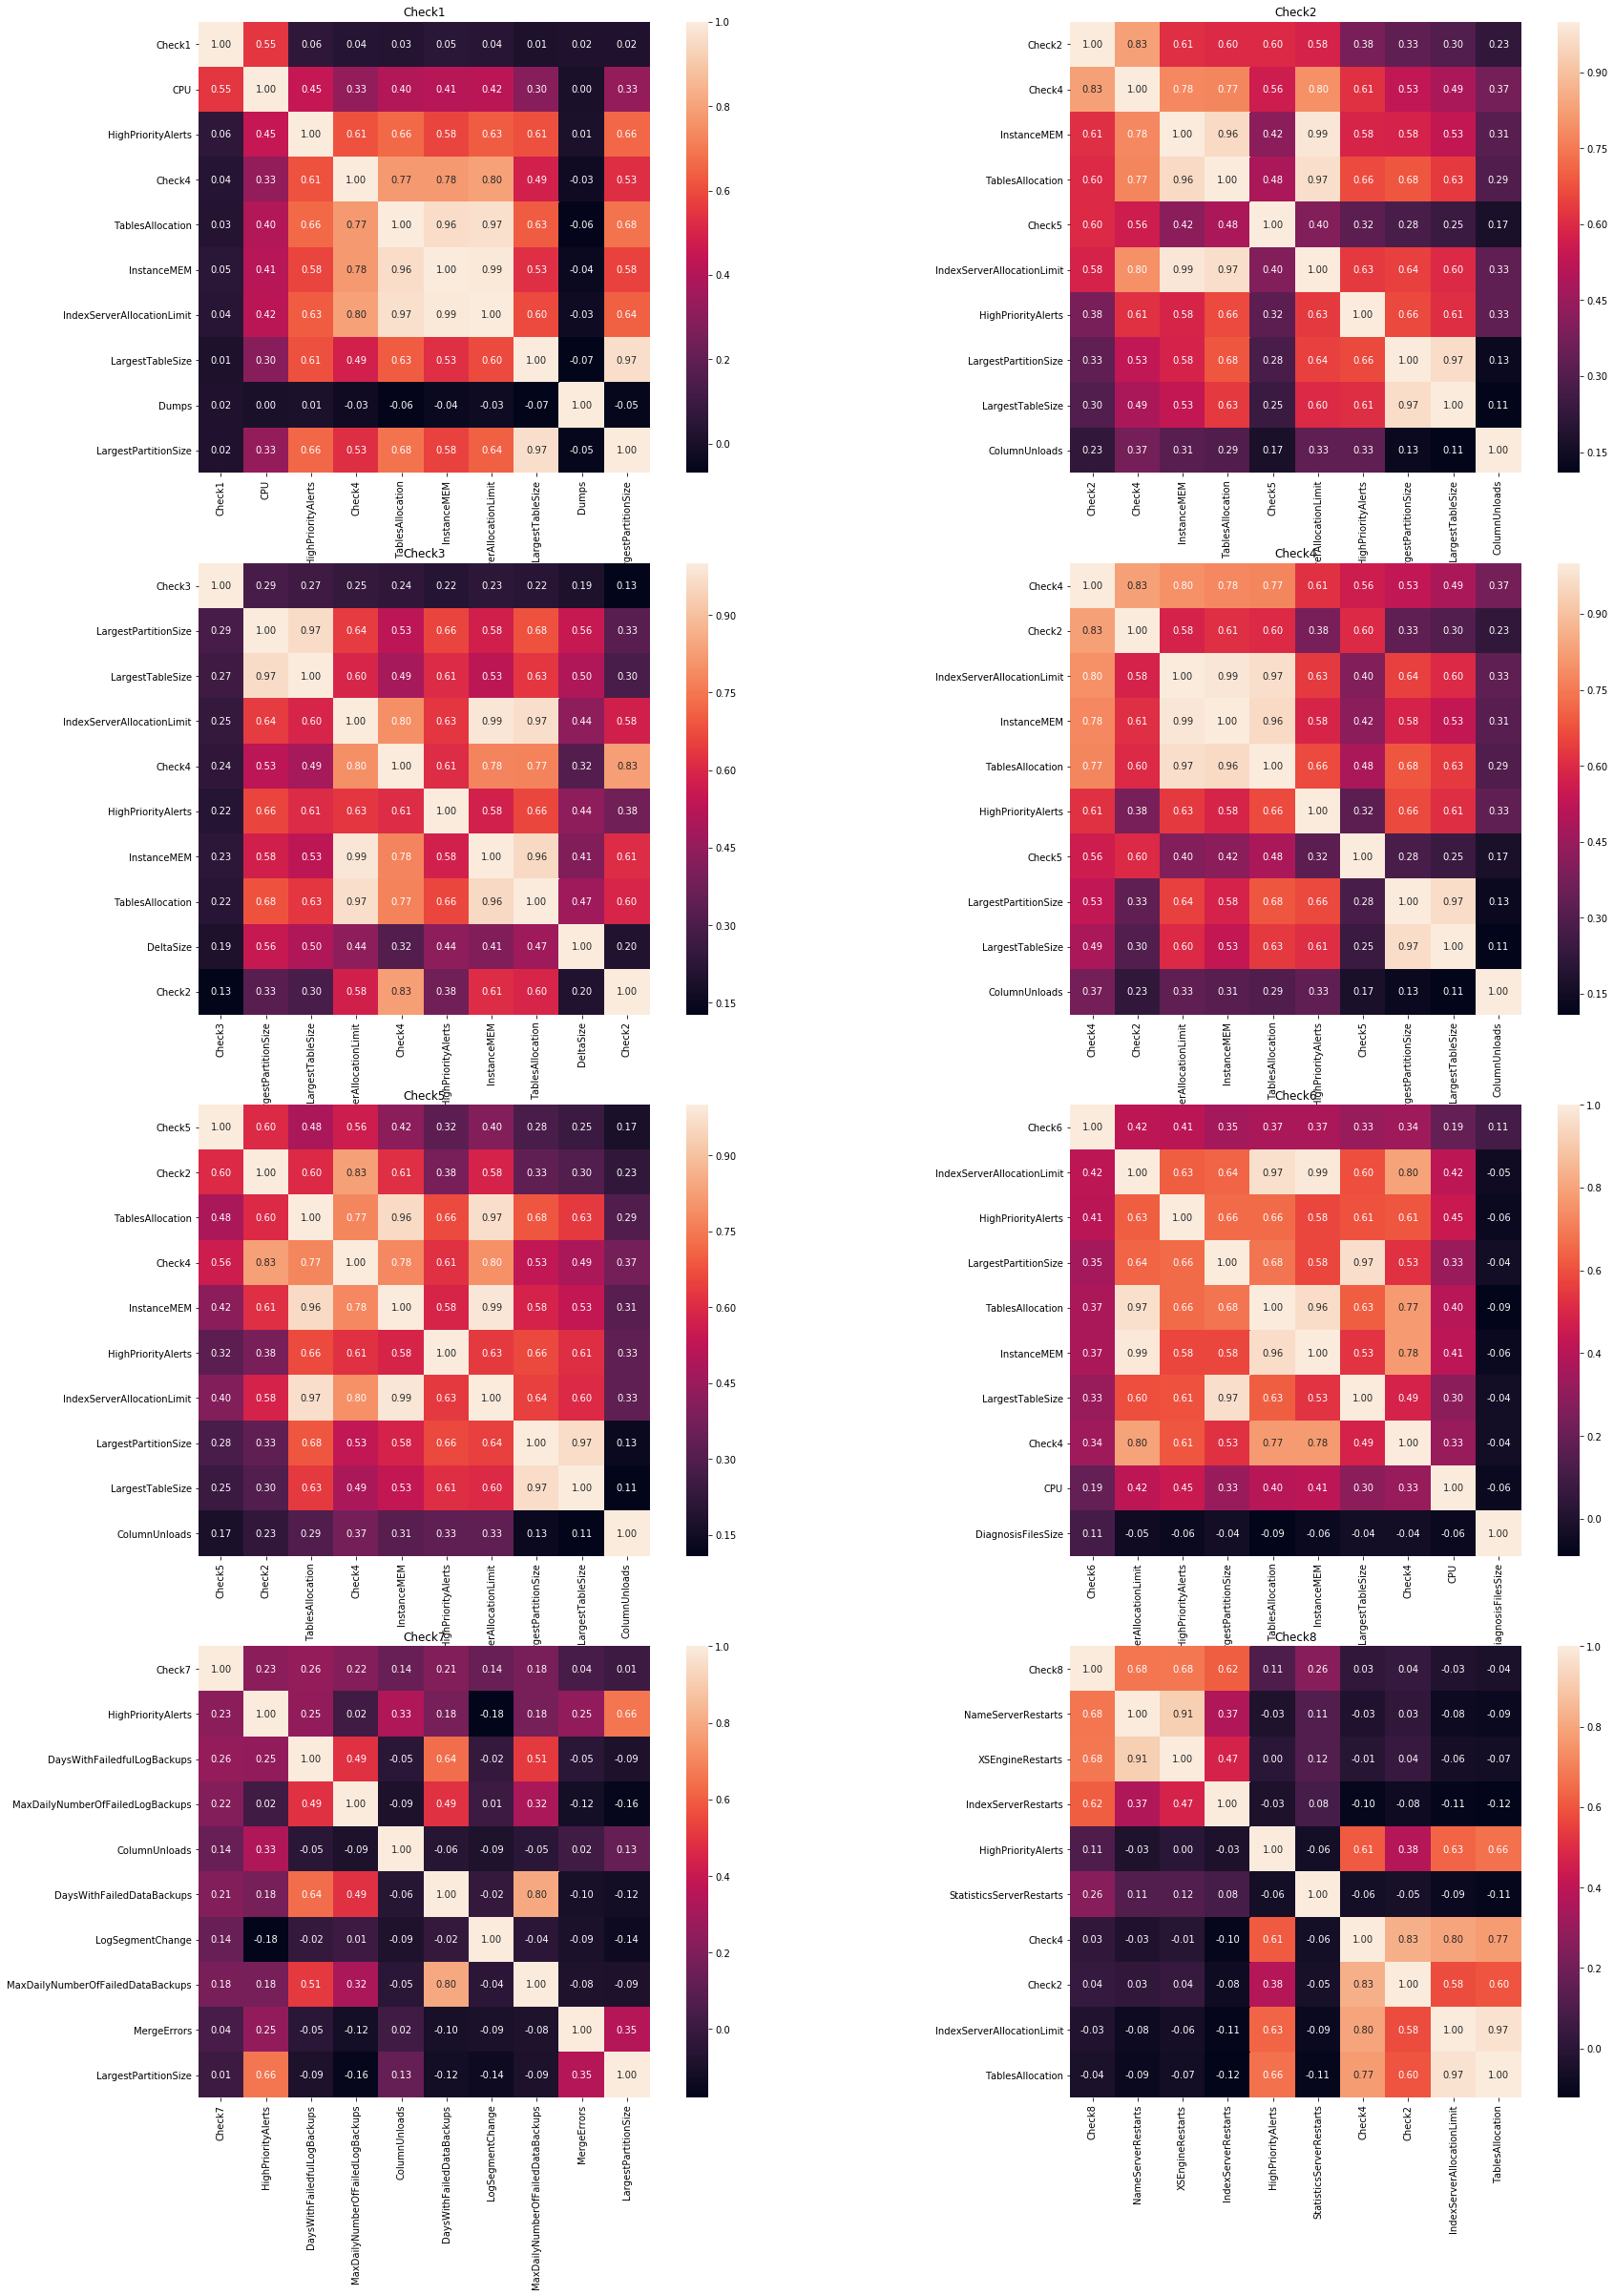

In [161]:
corrmat = dataset.corr()
f, ax = plt.subplots(nrows=4, ncols=2, figsize=(30, 40))
for i in range(8):
    label = 'Check'+str(i+1)
    cols = corrmat.nlargest(10, label)[label].index
    cm = np.corrcoef(corrmat[cols].values.T)
    hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', yticklabels=cols, xticklabels=cols, ax=ax[i // 2][ i % 2])
    ax[i // 2][ i % 2].set_title(label)
plt.show()

The plots above show that all the checks but *Check7* have quite strong correlation with at least one feature.

## 3. Model Selection

Below are defined some utility functions used in the modelization phase.

In [110]:
def train(dataset, model, check_no, verbose=False, average='weighted'):
    """
    Train the model according to the selected label
    """
    # splitting train and test dataset
    X_train, X_test, y_train, y_test = train_test_check_x(dataset, check_no)
    # fitting the model
    model = model.fit(X_train.values, y_train.values)
    # predict output
    y_pred = model.predict(X_test.values)
    if verbose:
        print("Scores on the label {}".format(check_no))
        print_scores(y_pred, y_test.values)
    score = f1_score(y_pred, y_test.values, average=average)
    return model, score

In [113]:
def train_all(dataset, model_initializer, verbose=False, average='weighted', model_args={}):
    """
    Utility function to train the model for all the labels
    """
    model_dict = {}
    scores = []

    for check_no in range(1, 9):
        dtc = model_initializer(**model_args)
        dtc, score = train(dataset, dtc, check_no, verbose, average)
        model_dict[check_no] = dtc
        scores.append(score)
    print("Average f1 score {0}: {1:.4f}".format(average, np.mean(scores)))
    return model_dict, scores

### 3.1 Decision Tree Classifier

In [112]:
tree_dict, scores = train_all(dataset, DecisionTreeClassifier, verbose=True)

Scores on the label 1
Score values of the model:
	F1 'macro' score: 99.17%
	F1 Binary score on label 0 : 99.99%
	F1 Binary score on label 1 : : 98.36%
	Accuracy 'macro' score: 99.17%
	Accuracy score: 99.98%

Scores on the label 2
Score values of the model:
	F1 'macro' score: 99.03%
	F1 Binary score on label 0 : 99.93%
	F1 Binary score on label 1 : : 98.12%
	Accuracy 'macro' score: 99.03%
	Accuracy score: 99.87%

Scores on the label 3
Score values of the model:
	F1 'macro' score: 98.18%
	F1 Binary score on label 0 : 99.89%
	F1 Binary score on label 1 : : 96.48%
	Accuracy 'macro' score: 98.18%
	Accuracy score: 99.78%

Scores on the label 4
Score values of the model:
	F1 'macro' score: 99.66%
	F1 Binary score on label 0 : 99.93%
	F1 Binary score on label 1 : : 99.39%
	Accuracy 'macro' score: 99.66%
	Accuracy score: 99.88%

Scores on the label 5
Score values of the model:
	F1 'macro' score: 98.85%
	F1 Binary score on label 0 : 99.97%
	F1 Binary score on label 1 : : 97.73%
	Accuracy 'macro'

We obtain an high accuracy in all the labels but in label 7

### 3.2 Random Forest Classifier

In [114]:
rfc_dict, rfc_scores = train_all(dataset, RandomForestClassifier, verbose=True)

Scores on the label 1
Score values of the model:
	F1 'macro' score: 99.54%
	F1 Binary score on label 0 : 99.99%
	F1 Binary score on label 1 : : 99.09%
	Accuracy 'macro' score: 99.54%
	Accuracy score: 99.99%

Scores on the label 2
Score values of the model:
	F1 'macro' score: 99.42%
	F1 Binary score on label 0 : 99.96%
	F1 Binary score on label 1 : : 98.87%
	Accuracy 'macro' score: 99.42%
	Accuracy score: 99.93%

Scores on the label 3
Score values of the model:
	F1 'macro' score: 98.66%
	F1 Binary score on label 0 : 99.92%
	F1 Binary score on label 1 : : 97.40%
	Accuracy 'macro' score: 98.66%
	Accuracy score: 99.84%

Scores on the label 4
Score values of the model:
	F1 'macro' score: 99.71%
	F1 Binary score on label 0 : 99.94%
	F1 Binary score on label 1 : : 99.48%
	Accuracy 'macro' score: 99.71%
	Accuracy score: 99.90%

Scores on the label 5
Score values of the model:
	F1 'macro' score: 98.84%
	F1 Binary score on label 0 : 99.97%
	F1 Binary score on label 1 : : 97.71%
	Accuracy 'macro'

The Random Forest Classifier is less interpretable model compared to the Decision Tree, but the accuracy on *Check7* is a bit higher.

### 3.3 Other models

For the sake of curiosity, we tried some non-interpretable model on *Check7* since the classification on this label has margin for improvements. Even though, we did not notice high accuracies. Below are shown two examples with *AdaBoostClassifier* and *GaussianNB*.

In [132]:
# abc_dict, abc_scores = train_all(cleaned_df, AdaBoostClassifier, verbose=True, n_estimators=10)
abc_model = AdaBoostClassifier(n_estimators=50)
abc_model, score = train(dataset, abc_model, 7, verbose=True, average='weighted')

Scores on the label 7
Score values of the model:
	F1 'macro' score: 77.49%
	F1 Binary score on label 0 : 98.76%
	F1 Binary score on label 1 : : 56.22%
	Accuracy 'macro' score: 77.49%
	Accuracy score: 97.58%



In [134]:
gnb_model = GaussianNB()
gnb_model, score = train(dataset, gnb_model, 7, verbose=True, average='weighted')

Scores on the label 7
Score values of the model:
	F1 'macro' score: 51.51%
	F1 Binary score on label 0 : 96.96%
	F1 Binary score on label 1 : : 6.05%
	Accuracy 'macro' score: 51.51%
	Accuracy score: 94.11%



### 3.4 Suggested Models
Here were tried the suggested models.
#### 3.4.1 Bayesian Rule Sets

In [41]:
# The algorithms are really heavy in terms of computation, so here we perform downsampling of the 0 class in order to: -Balance the dataset -downsample

df_majority = dataset_regular_behaviour
df_minority = dataset[dataset.Check7==1]

down_sample_num = len(df_minority) # perfect balancing between classes
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=down_sample_num)     # to match minority class
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

X_train, X_test, y_train, y_test = train_test_check_x(df_downsampled, 7)

model = BayesianRuleSet(method='forest', max_rules=30, max_iter=30)

y_train, y_test = np.uint64(y_train.values), np.uint64(y_test.values)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print_scores(y_pred, y_test)

/mnt/workspace/.local/lib/python3.5/site-packages/ruleset/__init__.py:269: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  tmps = sorted(list(zip(X[col].as_matrix(), y)))
/mnt/workspace/.local/lib/python3.5/site-packages/ruleset/__init__.py:353: RuntimeWarning: invalid value encountered in true_divide
  p1 = TP.astype(float) / (TP+FP)
/mnt/workspace/.local/lib/python3.5/site-packages/ruleset/__init__.py:546: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  working_X = X[name_meaning[0]].as_matrix()[working_idx]
/mnt/workspace/.local/lib/python3.5/site-packages/ruleset/__init__.py:564: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  working_X = X[name_meaning[1]].as_matrix()[working_idx]
/mnt/workspace/.local/lib/python3.5/site-packages/ruleset/__init__.py:850: RuntimeWarning: overflow encountered in exp
  alpha = np.exp(float(pt_new - pt_curr)/T)



** chain = 1, max at iter = 0 ** 
 accuracy = 0.528477190374431, TP = 308.0,FP = 1.0, TN = 5380.0, FN = 5074.0
 old is -999999999.9, pt_new is -7331.56863057282, prior_ChsRules=-17.338088412521756, likelihood_1 = -7.419812144458547, likelihood_2 = -7306.81073001584
 
['CPU<3.285', '37.0<=MinDailyNumberOfSuccessfulLogBackups', '16.5<=LogSegmentChange']
[28]

** chain = 1, max at iter = 1 ** 
 accuracy = 0.5544922419399796, TP = 589.0,FP = 2.0, TN = 5379.0, FN = 4793.0
 old is -7331.46863057282, pt_new is -7144.510317144959, prior_ChsRules=-33.95317943835107, likelihood_1 = -14.311755325824606, likelihood_2 = -7096.245382380784
 
['CPU<3.285', '37.0<=MinDailyNumberOfSuccessfulLogBackups', '16.5<=LogSegmentChange']
['PhysMEM<67.89', '322.0<=BlockingPhaseSec', '16.5<=LogSegmentChange']
[28, 23]

** chain = 1, max at iter = 7 ** 
 accuracy = 0.5846882839357057, TP = 913.0,FP = 1.0, TN = 5380.0, FN = 4469.0
 old is -7144.410317144959, pt_new is -6887.035287196085, prior_ChsRules=-33.9531794

Since the dataset given as input is balanced, the obtained score impiles that the classification performed is close to be random guessing. Therefore, it would lead to really bad performances in the complete dataset (which is quite unbalanced).

In addiction to that, the model is outperformed in terms of computation time by all the others.

#### 3.4.2 Scalable Bayesian Rules List

In [355]:
X_train, X_test, y_train, y_test = train_test_check_x(dataset, checkNo=2, reg_behaviour=True)
y_train = y_train.astype(np.uint8)
y_test = y_test.astype(np.uint8)
X_train['Check'] = y_train
X_test['Check'] = y_test

The numerical features must me discretized in order to use this model. Therefore, for each considered feature several bins have been defined.

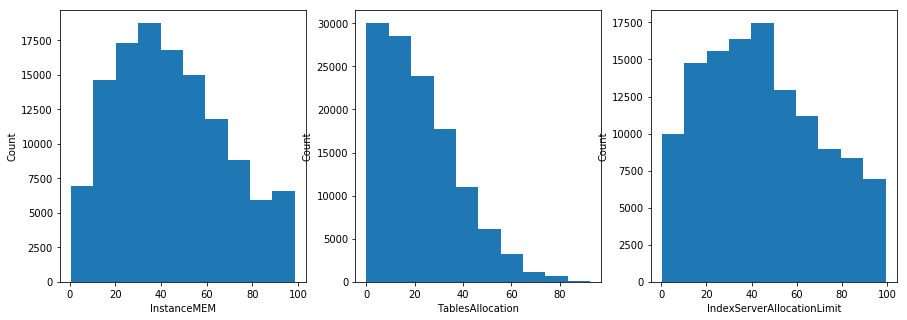

In [356]:
# most correlated features for Check2 (previously displayed)
nbins = 10
corr_feat = ['InstanceMEM', 'TablesAllocation', 'IndexServerAllocationLimit']
# display distribution
fig, ax = plt.subplots(ncols=len(corr_feat), figsize=(15,5))
for i in range(len(corr_feat)):
    ax[i].hist(X_train[corr_feat[i]], bins=nbins)
    ax[i].set_ylabel('Count')
    ax[i].set_xlabel(corr_feat[i])
plt.show()

The criteria to define the bins is *equi-depth*.

In [357]:
# equi-width bins don't have the same cardinality, it's better to procede with equi-depth bins
interval_df = pd.DataFrame()
for cf in corr_feat:
    interval_df[cf] = pd.qcut(X_train[cf], nbins)

intervals = {}
for cf in corr_feat:
    # last interval for each feature has to be changed in (const., +inf) to include all possible values for the test
    temp = np.sort(interval_df[cf].unique())
    last_int = pd.Interval(temp[-1].left, temp[-1].left + 300)
    temp[-1] = last_int

    maptest = {k : v for (k, v) in enumerate(temp)}
    intervals[cf] = pd.IntervalIndex(temp)
    X_train[cf] = pd.qcut(X_train[cf], nbins, labels=False)
    X_test[cf] = pd.cut(X_test[cf], intervals[cf])

The following cell contains the input file preparation for the training of the model. This file contains a line for each combination of training feature bin.  

To speed-up this process we decided to proceed with the 3-most correlated features for Check2.

In [358]:
# training file preparation
trainout = open('data/train.out', 'w')
trainlabel = open('data/train.label', 'w')

trainout.writelines('n_items: {}\n'.format(X_train[corr_feat[0]].nunique()**3 + 3*X_train[corr_feat[0]].nunique()**2 + 3*X_train[corr_feat[2]].nunique()))
trainout.writelines('n_samples: {}\n'.format(len(X_train)))

# inputs

# x y z
for im in X_train[corr_feat[0]].unique():
    for ta in X_train[corr_feat[1]].unique():
        for isal in X_train[corr_feat[2]].unique():
            X_train['x'] = 0
            idx = X_train[(X_train[corr_feat[0]]==im) & (X_train[corr_feat[1]]==ta) & (X_train[corr_feat[2]]==isal)].index
            X_train.loc[idx, 'x'] = 1
            trainout.writelines('{')
            values = (im, ta, isal)
            for i, x in enumerate(zip(corr_feat, values)):
                cf, v = x
                if i != len(corr_feat)-1:
                    trainout.writelines('{0}:{1},'.format(cf, v))
                else:
                    trainout.writelines('{0}:{1}'.format(cf, v))
            trainout.writelines('}')
            for v in X_train['x']:
                trainout.write(' {}'.format(v))
            trainout.write('\n')

# x
for i in range(len(corr_feat)):
    for im in X_train[corr_feat[i]].unique():
        X_train['x'] = 0
        idx = X_train[(X_train[corr_feat[i]]==im)].index
        X_train.loc[idx, 'x'] = 1
        trainout.writelines('{')
        trainout.writelines('{0}:{1}'.format(corr_feat[i], im))
        trainout.writelines('}')
        for v in X_train['x']:
            trainout.write(' {}'.format(v))
        trainout.write('\n')
        
# x y
for i in range(len(corr_feat)-1):
    cf1 = corr_feat[i]
    for j in range(1,len(corr_feat)):
        cf2 = corr_feat[j]
        
        for a in X_train[cf1].unique():
            for b in X_train[cf2].unique():
                X_train['x'] = 0
                idx = X_train[(X_train[cf1]==a) & (X_train[cf2]==b)].index
                X_train.loc[idx, 'x'] = 1
                trainout.writelines('{')
                trainout.writelines('{0}:{1},'.format(cf1, a))
                trainout.writelines('{0}:{1}'.format(cf2, b))
                trainout.writelines('}')
                for v in X_train['x']:
                    trainout.write(' {}'.format(v))
                trainout.write('\n')
            
trainout.close()

# labels
trainlabel.writelines('n_items: 2\n')
trainlabel.writelines('n_samples: {}\n'.format(len(X_train)))
trainlabel.writelines('{label=1}')
for c in X_train['Check'].values.tolist():
    trainlabel.write(' {}'.format(c))
trainlabel.write('\n')
trainlabel.writelines('{label=0}')
for c in X_train['Check'].values.tolist():
    c = 1 if c==0 else 0
    trainlabel.write(' {}'.format(c))


trainlabel.close()

In [363]:
# Model training
rule_ids, outputs, rule_strings = pysbrl.train_sbrl("data/train.out", "data/train.label", 20.0, eta=2.0, max_iters=2000, n_chains=10, alpha=[1,1])

Below are displayed the rules and their probabilities.

In [364]:
rules = [rule_strings[i] for i in rule_ids]

print('if ' + rules[0] + ', probability for Check2 to be 1 = {0}'.format(outputs[0][0]))
for rule, prob in zip(rules[1:], outputs[1:]):
    print('else if ' + rule + ', probability for Check2 to be 1 = {0}'.format(prob[0]))

if {InstanceMEM:9,TablesAllocation:9,IndexServerAllocationLimit:9}, probability for Check2 to be 1 = 0.7630491351599571
else if {InstanceMEM:9,TablesAllocation:2}, probability for Check2 to be 1 = 0.19333333333333333
else if {InstanceMEM:9,IndexServerAllocationLimit:4}, probability for Check2 to be 1 = 0.2644135188866799
else if {InstanceMEM:9,TablesAllocation:5,IndexServerAllocationLimit:9}, probability for Check2 to be 1 = 0.42857142857142855
else if {TablesAllocation:7,TablesAllocation:2}, probability for Check2 to be 1 = 0.5
else if {InstanceMEM:9,IndexServerAllocationLimit:9}, probability for Check2 to be 1 = 0.2926829268292683
else if {InstanceMEM:9}, probability for Check2 to be 1 = 0.041708043694141016
else if default, probability for Check2 to be 1 = 1.8143716377425587e-05


For some rules the confidence of the output of the model is relatively high. However, the efficency and ease of use of this model cannot be compared to the decision tree approach since here we consider just 3 features and a limited number of bins due to the storage cost of the input file by the model.

In [365]:
first_rule = X_test[(X_test[corr_feat[0]]==map2[9]) & (X_test[corr_feat[1]]==map2[9]) & (X_test[corr_feat[2]]==map2[9])]
print('Total number of samples on Test satisfing the first rule:', len(first_rule))
anomalies = first_rule[first_rule['Check']==1]
print('Total number of samples on Test satisfing the first rule with Check2==1:', len(anomalies))

if len(first_rule) != 0:
    prob_test = len(anomalies)/len(first_rule)
else:
    prob_test = 0

print('Probability on test: {0:.2f}\nProbability on train: {1:.2f}'.format(prob_test, outputs[0][0]))

Total number of samples on Test satisfing the first rule: 2782
Total number of samples on Test satisfing the first rule with Check2==1: 2137
Probability on test: 0.77
Probability on train: 0.76


To trivially prove the validity of the model, the first rule is applied to the test dataset and the result shows that the probability of Check2==1 for the samples following this rule is comparable with the one provided with train dataset.

## 4. Parameters Optimization
The obtained results show that both decision tree and random forest are good models for this kind of problem.  
In the case of *Check7*, performance could still improve with different hyper-parameters.

In [116]:
def get_cardinality_of_exploration(d):
    """Return the cardinality of the grid"""
    return reduce(lambda a, b: a * b, [len(i) for i in d.values()])


def OptimiseParameters(model, X, y, parameters_grid, n_jobs=1, scoring='f1_macro', instantiated=False):
    """
    Optimize the accuracy of the model across different parameters configurations generated by the grid using Cross Validation
    """
    # This option allows to pass an unistantiated model to the function
    if not instantiated:
        modelCV = model()
    # The GridSearchCV class allows to explore all the parameters configurations generated by the grid
    cross_validation_model = GridSearchCV(estimator=modelCV, param_grid=parameters_grid, cv=10, n_jobs=n_jobs, scoring=scoring)
    cross_validation_model.fit(X, y)
    print("Best parameters configuration: {}\n".format(cross_validation_model.best_params_))
    print("Best {0} score: {1:.2f}\n".format(scoring, cross_validation_model.best_score_))
    # best model is returned
    return cross_validation_model

### 4.1 Decision Tree Parameters Optimization

In [119]:
# parameters to optimize
check_nums = list(range(1, 9))
# we tune on label 7 afterwards
check_nums.remove(7)

optimized_tree = {}
f1_macro_scores = {}
f1_scores = {}

for check_num in check_nums:
    X_train, X_test, y_train, y_test = train_test_check_x(dataset, check_num)

    now = time()

    # lambda, alpha, eta, gamma
    parameters_grid = {
        'criterion': ['gini', 'entropy'],
    }

    print("[DecisionTree] Cardinatilty of grid: ", get_cardinality_of_exploration(parameters_grid))
    dtc_model_cv = OptimiseParameters(DecisionTreeClassifier, X_train, y_train, parameters_grid=parameters_grid, n_jobs=4, scoring='f1_macro')   
    after = time()
    print("[DecisionTree] parameters, time: ", after - now)
    y_pred = dtc_model_cv.best_estimator_.predict(X_test.values)
    # predict using best model
    print("Scores on the label {}".format(check_num))
    print_scores(y_pred, y_test.values)
    f1_macro_scores[check_num] = f1_score(y_pred, y_test.values, average='macro')
    f1_scores[check_num] = f1_score(y_pred, y_test.values)
    optimized_tree[check_num] = dtc_model_cv.best_estimator_

[DecisionTree] Cardinatilty of grid:  2
Best parameters configuration: {'criterion': 'gini'}

Best f1_macro score: 0.99

[DecisionTree] parameters, time:  4.048858880996704
Scores on the label 1
Score values of the model:
	F1 'macro' score: 99.38%
	F1 Binary score on label 0 : 99.99%
	F1 Binary score on label 1 : : 98.77%
	Accuracy 'macro' score: 99.38%
	Accuracy score: 99.98%

[DecisionTree] Cardinatilty of grid:  2
Best parameters configuration: {'criterion': 'gini'}

Best f1_macro score: 0.99

[DecisionTree] parameters, time:  6.542269706726074
Scores on the label 2
Score values of the model:
	F1 'macro' score: 99.37%
	F1 Binary score on label 0 : 99.96%
	F1 Binary score on label 1 : : 98.78%
	Accuracy 'macro' score: 99.37%
	Accuracy score: 99.92%

[DecisionTree] Cardinatilty of grid:  2
Best parameters configuration: {'criterion': 'entropy'}

Best f1_macro score: 0.98

[DecisionTree] parameters, time:  6.632298707962036
Scores on the label 3
Score values of the model:
	F1 'macro' s

#### 4.1.2 Check7, a bit more of parameters tuning

In [120]:
X_train, X_test, y_train, y_test = train_test_check_x(dataset, 7)

now = time()

# lambda, alpha, eta, gamma
parameters_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : [10, 15, 20, 25]
}

print("[DecisionTree] Cardinatilty of grid: ", get_cardinality_of_exploration(parameters_grid))
dtc_model_cv = OptimiseParameters(DecisionTreeClassifier, X_train, y_train, parameters_grid=parameters_grid, n_jobs=4, scoring='f1_macro')   
after = time()
print("[DecisionTree] parameters, time: ", after - now)

print(dtc_model_cv.best_estimator_)
# predict using best model
y_pred = dtc_model_cv.best_estimator_.predict(X_test.values)
print("Scores on the label 7")
optmized_tree = print_scores(y_pred, y_test.values)

f1_macro_scores[7] = f1_score(y_pred, y_test.values, average='macro')
f1_scores[7] = f1_score(y_pred, y_test.values)
optimized_tree[7] = dtc_model_cv.best_estimator_

[DecisionTree] Cardinatilty of grid:  8
Best parameters configuration: {'criterion': 'entropy', 'max_depth': 20}

Best f1_macro score: 0.83

[DecisionTree] parameters, time:  88.32244610786438
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=20,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Scores on the label 7
Score values of the model:
	F1 'macro' score: 83.11%
	F1 Binary score on label 0 : 98.96%
	F1 Binary score on label 1 : : 67.26%
	Accuracy 'macro' score: 83.11%
	Accuracy score: 97.99%



### 4.2 Random Forest Parameters Optimization

In [121]:
X_train, X_test, y_train, y_test = train_test_check_x(dataset, 7)

now = time()

parameters_grid = {
    'n_estimators' :[30, 50],
    'max_depth' : [20, 30],
    'criterion': ['gini', 'entropy']
}

print("[Random Forest] Cardinatilty of grid: ", get_cardinality_of_exploration(parameters_grid))
rfc_model_cv = OptimiseParameters(RandomForestClassifier, X_train, y_train, parameters_grid=parameters_grid, n_jobs=4, scoring='f1_macro')   
after = time()
print("[Random Forest] parameters, time: ", after - now)

print(rfc_model_cv.best_estimator_)
# predict using best model
y_pred = rfc_model_cv.best_estimator_.predict(X_test.values)
print("Scores on the label 7")
print_scores(y_pred, y_test.values)
optimized_tree[7] = rfc_model_cv.best_estimator_
f1_macro_scores[7] = f1_score(y_pred, y_test.values, average='macro')
f1_scores[7] = f1_score(y_pred, y_test.values)

[Random Forest] Cardinatilty of grid:  8
Best parameters configuration: {'criterion': 'gini', 'max_depth': 30, 'n_estimators': 50}

Best f1_macro score: 0.86

[Random Forest] parameters, time:  503.23709082603455
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Scores on the label 7
Score values of the model:
	F1 'macro' score: 86.84%
	F1 Binary score on label 0 : 99.30%
	F1 Binary score on label 1 : : 74.39%
	Accuracy 'macro' score: 86.84%
	Accuracy score: 98.64%



### 5. Interpret the models
From our hypotesis, the data are taken from a log system of SAP HANA DB.
So the anomalies could concern the anomalyes on the DB system.

We obtained a really high accuracy with a really high degree of interpretability.

To interpret the decision tree, we train tree with really low depth and then we extract the rule

In [129]:
k_args = {'max_depth' : 3}
cut_tree_dict, cut_scores = train_all(dataset, DecisionTreeClassifier, verbose=True, model_args=k_args)

Scores on the label 1
Score values of the model:
	F1 'macro' score: 98.98%
	F1 Binary score on label 0 : 99.99%
	F1 Binary score on label 1 : : 97.97%
	Accuracy 'macro' score: 98.98%
	Accuracy score: 99.97%

Scores on the label 2
Score values of the model:
	F1 'macro' score: 98.75%
	F1 Binary score on label 0 : 99.92%
	F1 Binary score on label 1 : : 97.58%
	Accuracy 'macro' score: 98.75%
	Accuracy score: 99.84%

Scores on the label 3
Score values of the model:
	F1 'macro' score: 96.75%
	F1 Binary score on label 0 : 99.81%
	F1 Binary score on label 1 : : 93.69%
	Accuracy 'macro' score: 96.75%
	Accuracy score: 99.63%

Scores on the label 4
Score values of the model:
	F1 'macro' score: 99.38%
	F1 Binary score on label 0 : 99.88%
	F1 Binary score on label 1 : : 98.89%
	Accuracy 'macro' score: 99.38%
	Accuracy score: 99.78%

Scores on the label 5
Score values of the model:
	F1 'macro' score: 98.05%
	F1 Binary score on label 0 : 99.95%
	F1 Binary score on label 1 : : 96.15%
	Accuracy 'macro'

Is it possible to notice a really high accuracy with just 3 as *max_depth* of the tree.

Using dot function of graphviz library is it possible to display the decision tree.

In [125]:
# Exporting the cut tree
keys = list(set(dataset.keys()) - set(check_names))
for i in range(1, 9):
    a = export_graphviz(cut_tree_dict[i], out_file='tree/dot_cut/cut_tree{}.dot'.format(i), feature_names=keys)

##### **Label 1**
<div> 
    <img src='https://imagizer.imageshack.com/img921/8051/K7y6DA.png' > </img>
</div>
<div>
    This is a memory-related error: the space used for tables allocation has exceeded a certain threshold. 
</div>

##### **Label 2**
<div > 
    <img src='https://imagizer.imageshack.com/img924/2919/77U7hQ.png' > </img>
</div>
<div>
    This seems to be mostly correlated with some condition causing the database to perform too many daily log backups, causing the alert. 
</div>

##### **Label 3**
<div> 
    <img src='https://imagizer.imageshack.com/img924/1821/nxjlmh.png' > </img>
</div>
<div>
The alert seems correlated with a grat number of 'High Priority Alerts'. However, it is unlikely this is the root cause, but more probably is a symptom of some other precise failure.
</div>

##### **Label 4**
<div> 
    <img src='https://imagizer.imageshack.com/img923/1600/aVNA67.png'> </img>
</div>
<div>
    This alert seems to be triggered when the data of the database has failed to be backupped enough frequently (in particular every 90 days). 
</div>

##### **Label 5**
<div> 
    <img src='https://imagizer.imageshack.com/img923/479/h4RnTi.png'> </img>
</div>
<div>
    The alert seems mostly correlated to an high number of Index Server Restarts.
</div>

##### **Label 6**
<div> 
    <img src='https://imagizer.imageshack.com/img923/8236/Dwq5tf.png'> </img>
</div>
<div>
The alert is triggered when more than a certain number of columns is unloaded.
</div>

##### **Label 7**
<div> 
    <img src='https://imagizer.imageshack.com/img923/3555/OKBrC6.png'> </img>
</div>
<div>
    It is not possible to interpret this tree, as the count of the alert is almost equally split from side to side as we progress down the tree. 
</div>

##### **Label 8**
<div> 
    <img src='https://imagizer.imageshack.com/img921/883/kp4ugG.png'> </img>
</div>
<div>
    The alert is probably triggered in the event of a Out Of Memory Dump with failure of a Log Backup. We can observe, in fact, that it is present when the number of OOMDumps is 3 or more, or when it is less but there have been failed Log Backups. We consider likely that an as the number of OOM failures increases, there is an higher probability of failing a Log Backup, reaching, we speculate, the certainity as the number of OOM is 3.
</div>

## 6. Conclusion and final scores
Since the dataset is quite unbalanced, and the detection of the anomalies is really imported, we used f1 **macro** to as a parameter to optimize and to evalute the performance of the model. Also, we kept track of the standard f1 score ("binary"). The considered scores are the achived ones from the optimized decision trees.

We were not able to provide an interpretation of the Check7 anomalies, so we do not believe there is any advantage to use an interpretable model rather than a uninterpretable one. For this reason the score con Check7 is the one of the Random Tree Classifier.

In [137]:
for i in range(1, 9):
    print("Check{} f1 score: {:.3f} f1 macro score: {:.3f}".format(i, f1_scores[i], f1_macro_scores[i]))
print("F1 score mean value among all the labels: {:.3f}".format(np.mean(list(f1_scores.values()))))
print("F1 macro score mean value among all the labels: {:.3f}".format(np.mean(list(f1_macro_scores.values()))))

Check1 f1 score: 0.988 f1 macro score: 0.994
Check2 f1 score: 0.988 f1 macro score: 0.994
Check3 f1 score: 0.971 f1 macro score: 0.985
Check4 f1 score: 0.994 f1 macro score: 0.996
Check5 f1 score: 0.978 f1 macro score: 0.989
Check6 f1 score: 0.989 f1 macro score: 0.992
Check7 f1 score: 0.868 f1 macro score: 0.986
Check8 f1 score: 1.000 f1 macro score: 1.000
F1 score mean value among all the labels: 0.972
F1 macro score mean value among all the labels: 0.992
